In [61]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [62]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 6 with the lowest memory usage.


In [63]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [64]:
spot_size=50
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.5
dataset_name="hBreast"
kmeans_init=True
custom_init="K-Means"
spatial_init=True
num_clusters=17
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00

In [65]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [66]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [67]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, K=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=False, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=False, K=K)[1.0]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

100%|██████████| 23444/23444 [00:01<00:00, 13009.50it/s]


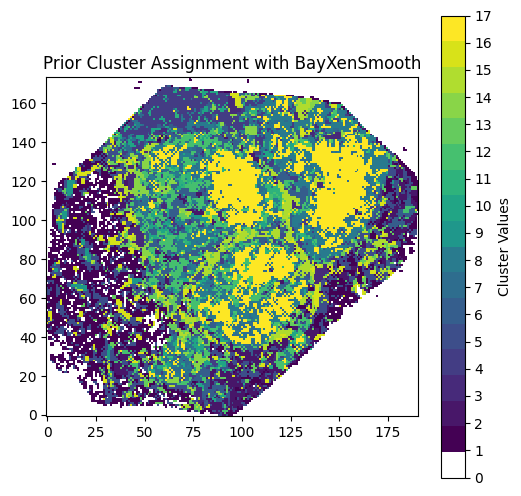

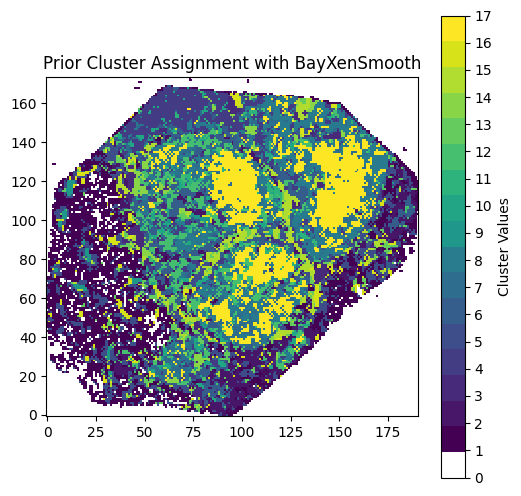

In [68]:
# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 100

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init)

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/wss.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [69]:
# grab the WSS distance of cluster labels
wss = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(wss.values()) / 1_000_000

2.813571964438005

In [70]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [71]:
learn_global_variances = True

In [72]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [73]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([17, 3]), torch.Size([17, 3]))

In [74]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [75]:
pyro.clear_param_store()
NUM_EPOCHS = 500
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.005, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 10
patience_counter = 0
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])
        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 0:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1:   0%|          | 1/500 [00:01<09:07,  1.10s/it]

Epoch 0 : loss = 12728.9809
tensor([0.8525, 0.0095, 0.0095, 0.0085, 0.0102, 0.0081, 0.0093, 0.0094, 0.0098,
        0.0101, 0.0084, 0.0082, 0.0095, 0.0087, 0.0092, 0.0096, 0.0097],
       dtype=torch.float64)


Epoch 2:   0%|          | 2/500 [00:02<08:58,  1.08s/it]

Epoch 1 : loss = 12003.1692
tensor([0.8529, 0.0098, 0.0092, 0.0090, 0.0097, 0.0085, 0.0092, 0.0092, 0.0094,
        0.0096, 0.0088, 0.0087, 0.0092, 0.0091, 0.0093, 0.0093, 0.0093],
       dtype=torch.float64)


Epoch 3:   1%|          | 3/500 [00:02<07:53,  1.05it/s]

Epoch 2 : loss = 11409.125
tensor([0.8580, 0.0093, 0.0090, 0.0090, 0.0091, 0.0085, 0.0092, 0.0089, 0.0088,
        0.0090, 0.0087, 0.0086, 0.0087, 0.0091, 0.0086, 0.0088, 0.0088],
       dtype=torch.float64)


Epoch 4:   1%|          | 4/500 [00:03<07:30,  1.10it/s]

Epoch 3 : loss = 10923.374
tensor([0.8653, 0.0086, 0.0085, 0.0082, 0.0085, 0.0083, 0.0087, 0.0082, 0.0085,
        0.0084, 0.0084, 0.0084, 0.0082, 0.0085, 0.0086, 0.0083, 0.0085],
       dtype=torch.float64)


Epoch 5:   1%|          | 5/500 [00:04<07:03,  1.17it/s]

Epoch 4 : loss = 10562.5031
tensor([0.8652, 0.0085, 0.0085, 0.0083, 0.0084, 0.0084, 0.0083, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0087, 0.0085, 0.0084, 0.0084, 0.0083],
       dtype=torch.float64)


Epoch 6:   1%|          | 6/500 [00:05<07:07,  1.15it/s]

Epoch 5 : loss = 10287.2135
tensor([0.8646, 0.0086, 0.0085, 0.0084, 0.0085, 0.0085, 0.0083, 0.0084, 0.0084,
        0.0084, 0.0085, 0.0084, 0.0088, 0.0086, 0.0083, 0.0085, 0.0083],
       dtype=torch.float64)


Epoch 7:   1%|▏         | 7/500 [00:06<07:13,  1.14it/s]

Epoch 6 : loss = 10065.9974
tensor([0.8646, 0.0086, 0.0085, 0.0084, 0.0085, 0.0085, 0.0083, 0.0084, 0.0084,
        0.0084, 0.0085, 0.0084, 0.0088, 0.0086, 0.0083, 0.0085, 0.0083],
       dtype=torch.float64)


Epoch 8:   2%|▏         | 8/500 [00:07<07:28,  1.10it/s]

Epoch 7 : loss = 9895.2306
tensor([0.8646, 0.0086, 0.0085, 0.0084, 0.0085, 0.0085, 0.0083, 0.0084, 0.0084,
        0.0084, 0.0085, 0.0084, 0.0088, 0.0086, 0.0083, 0.0085, 0.0083],
       dtype=torch.float64)


Epoch 9:   2%|▏         | 9/500 [00:08<07:33,  1.08it/s]

Epoch 8 : loss = 9786.549
tensor([0.8688, 0.0082, 0.0080, 0.0081, 0.0083, 0.0082, 0.0083, 0.0083, 0.0081,
        0.0081, 0.0081, 0.0082, 0.0082, 0.0082, 0.0083, 0.0082, 0.0083],
       dtype=torch.float64)


Epoch 10:   2%|▏         | 10/500 [00:09<07:40,  1.06it/s]

Epoch 9 : loss = 9690.4719
tensor([0.8694, 0.0083, 0.0080, 0.0082, 0.0082, 0.0082, 0.0081, 0.0082, 0.0082,
        0.0082, 0.0082, 0.0081, 0.0082, 0.0082, 0.0081, 0.0082, 0.0082],
       dtype=torch.float64)


Epoch 11:   2%|▏         | 11/500 [00:10<07:33,  1.08it/s]

Epoch 10 : loss = 9611.7607
tensor([0.8695, 0.0083, 0.0079, 0.0081, 0.0082, 0.0082, 0.0081, 0.0082, 0.0082,
        0.0082, 0.0082, 0.0081, 0.0082, 0.0081, 0.0081, 0.0082, 0.0082],
       dtype=torch.float64)


Epoch 12:   2%|▏         | 12/500 [00:11<07:40,  1.06it/s]

Epoch 11 : loss = 9562.8474
tensor([0.8695, 0.0083, 0.0079, 0.0081, 0.0082, 0.0082, 0.0081, 0.0082, 0.0082,
        0.0082, 0.0082, 0.0081, 0.0082, 0.0081, 0.0081, 0.0082, 0.0082],
       dtype=torch.float64)


Epoch 13:   3%|▎         | 13/500 [00:12<07:32,  1.08it/s]

Epoch 12 : loss = 9517.4324
tensor([0.8705, 0.0083, 0.0083, 0.0081, 0.0081, 0.0081, 0.0080, 0.0080, 0.0081,
        0.0081, 0.0080, 0.0080, 0.0080, 0.0081, 0.0082, 0.0079, 0.0081],
       dtype=torch.float64)


Epoch 14:   3%|▎         | 14/500 [00:12<07:30,  1.08it/s]

Epoch 13 : loss = 9471.2726
tensor([0.8705, 0.0083, 0.0083, 0.0081, 0.0081, 0.0081, 0.0080, 0.0080, 0.0081,
        0.0081, 0.0080, 0.0080, 0.0080, 0.0081, 0.0082, 0.0079, 0.0081],
       dtype=torch.float64)


Epoch 15:   3%|▎         | 15/500 [00:13<07:43,  1.05it/s]

Epoch 14 : loss = 9422.5666
tensor([0.8735, 0.0080, 0.0078, 0.0081, 0.0080, 0.0079, 0.0078, 0.0076, 0.0080,
        0.0080, 0.0078, 0.0080, 0.0080, 0.0080, 0.0077, 0.0080, 0.0078],
       dtype=torch.float64)


Epoch 16:   3%|▎         | 16/500 [00:14<07:42,  1.05it/s]

Epoch 15 : loss = 9397.9429
tensor([0.8741, 0.0079, 0.0079, 0.0081, 0.0079, 0.0079, 0.0078, 0.0079, 0.0079,
        0.0078, 0.0078, 0.0078, 0.0079, 0.0078, 0.0079, 0.0077, 0.0078],
       dtype=torch.float64)


Epoch 17:   3%|▎         | 17/500 [00:15<07:39,  1.05it/s]

Epoch 16 : loss = 9361.6882
tensor([0.8795, 0.0076, 0.0071, 0.0074, 0.0076, 0.0076, 0.0075, 0.0070, 0.0075,
        0.0076, 0.0074, 0.0076, 0.0076, 0.0077, 0.0076, 0.0081, 0.0075],
       dtype=torch.float64)


Epoch 18:   4%|▎         | 18/500 [00:16<07:25,  1.08it/s]

Epoch 17 : loss = 9338.5136
tensor([0.8796, 0.0076, 0.0071, 0.0074, 0.0076, 0.0076, 0.0075, 0.0070, 0.0075,
        0.0076, 0.0074, 0.0076, 0.0076, 0.0077, 0.0076, 0.0081, 0.0075],
       dtype=torch.float64)


Epoch 19:   4%|▍         | 19/500 [00:17<07:30,  1.07it/s]

Epoch 18 : loss = 9334.9873
tensor([0.8796, 0.0076, 0.0071, 0.0074, 0.0076, 0.0076, 0.0075, 0.0070, 0.0075,
        0.0076, 0.0074, 0.0076, 0.0076, 0.0077, 0.0076, 0.0081, 0.0075],
       dtype=torch.float64)


Epoch 20:   4%|▍         | 20/500 [00:18<07:21,  1.09it/s]

Epoch 19 : loss = 9309.4763
tensor([0.8780, 0.0077, 0.0077, 0.0077, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0075, 0.0077, 0.0076, 0.0076, 0.0074, 0.0075],
       dtype=torch.float64)


Epoch 21:   4%|▍         | 21/500 [00:19<07:31,  1.06it/s]

Epoch 20 : loss = 9300.6812
tensor([0.8738, 0.0079, 0.0074, 0.0088, 0.0078, 0.0079, 0.0077, 0.0079, 0.0079,
        0.0078, 0.0079, 0.0079, 0.0076, 0.0080, 0.0078, 0.0082, 0.0076],
       dtype=torch.float64)


Epoch 22:   4%|▍         | 22/500 [00:20<07:32,  1.06it/s]

Epoch 21 : loss = 9272.8217
tensor([0.8737, 0.0079, 0.0074, 0.0089, 0.0078, 0.0079, 0.0077, 0.0079, 0.0079,
        0.0078, 0.0079, 0.0079, 0.0076, 0.0080, 0.0078, 0.0082, 0.0076],
       dtype=torch.float64)


Epoch 23:   5%|▍         | 23/500 [00:21<07:17,  1.09it/s]

Epoch 22 : loss = 9238.0949
tensor([0.8751, 0.0080, 0.0077, 0.0084, 0.0078, 0.0078, 0.0081, 0.0076, 0.0076,
        0.0076, 0.0078, 0.0077, 0.0080, 0.0077, 0.0076, 0.0077, 0.0078],
       dtype=torch.float64)


Epoch 24:   5%|▍         | 24/500 [00:22<07:34,  1.05it/s]

Epoch 23 : loss = 9246.6687
tensor([0.8816, 0.0073, 0.0074, 0.0077, 0.0074, 0.0074, 0.0073, 0.0074, 0.0076,
        0.0074, 0.0074, 0.0073, 0.0074, 0.0074, 0.0074, 0.0073, 0.0073],
       dtype=torch.float64)


Epoch 25:   5%|▌         | 25/500 [00:23<07:15,  1.09it/s]

Epoch 24 : loss = 9206.8813
tensor([0.8832, 0.0075, 0.0072, 0.0075, 0.0074, 0.0073, 0.0073, 0.0072, 0.0072,
        0.0070, 0.0071, 0.0072, 0.0074, 0.0074, 0.0073, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 26:   5%|▌         | 26/500 [00:24<07:10,  1.10it/s]

Epoch 25 : loss = 9236.3493
tensor([0.8746, 0.0077, 0.0079, 0.0087, 0.0077, 0.0078, 0.0079, 0.0078, 0.0080,
        0.0078, 0.0077, 0.0079, 0.0077, 0.0078, 0.0078, 0.0077, 0.0076],
       dtype=torch.float64)


Epoch 27:   5%|▌         | 27/500 [00:25<07:20,  1.07it/s]

Epoch 26 : loss = 9180.2368
tensor([0.8744, 0.0077, 0.0079, 0.0087, 0.0077, 0.0078, 0.0079, 0.0079, 0.0080,
        0.0078, 0.0077, 0.0079, 0.0077, 0.0079, 0.0079, 0.0077, 0.0076],
       dtype=torch.float64)


Epoch 28:   6%|▌         | 28/500 [00:26<08:26,  1.07s/it]

Epoch 27 : loss = 9189.8117
tensor([0.8773, 0.0078, 0.0075, 0.0082, 0.0078, 0.0077, 0.0076, 0.0076, 0.0076,
        0.0077, 0.0076, 0.0073, 0.0078, 0.0076, 0.0076, 0.0076, 0.0077],
       dtype=torch.float64)


Epoch 29:   6%|▌         | 29/500 [00:27<09:08,  1.17s/it]

Epoch 28 : loss = 9149.4505
tensor([0.8809, 0.0071, 0.0075, 0.0076, 0.0075, 0.0075, 0.0074, 0.0076, 0.0076,
        0.0074, 0.0075, 0.0076, 0.0075, 0.0074, 0.0072, 0.0075, 0.0074],
       dtype=torch.float64)


Epoch 30:   6%|▌         | 30/500 [00:29<09:04,  1.16s/it]

Epoch 29 : loss = 9156.7119
tensor([0.8808, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0078, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 31:   6%|▌         | 31/500 [00:30<08:59,  1.15s/it]

Epoch 30 : loss = 9145.0904
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 32:   6%|▋         | 32/500 [00:31<08:45,  1.12s/it]

Epoch 31 : loss = 9113.1453
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 33:   7%|▋         | 33/500 [00:31<07:49,  1.00s/it]

Epoch 32 : loss = 9118.1216
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 34:   7%|▋         | 34/500 [00:32<07:12,  1.08it/s]

Epoch 33 : loss = 9103.5025
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 35:   7%|▋         | 35/500 [00:33<06:54,  1.12it/s]

Epoch 34 : loss = 9094.6965
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 36:   7%|▋         | 36/500 [00:34<07:11,  1.07it/s]

Epoch 35 : loss = 9092.9384
tensor([0.8807, 0.0079, 0.0074, 0.0077, 0.0075, 0.0074, 0.0076, 0.0074, 0.0072,
        0.0074, 0.0074, 0.0072, 0.0073, 0.0074, 0.0079, 0.0073, 0.0074],
       dtype=torch.float64)


Epoch 37:   7%|▋         | 37/500 [00:35<08:18,  1.08s/it]

Epoch 36 : loss = 9066.9464
tensor([0.8865, 0.0071, 0.0072, 0.0075, 0.0071, 0.0071, 0.0070, 0.0071, 0.0069,
        0.0069, 0.0072, 0.0072, 0.0071, 0.0070, 0.0070, 0.0070, 0.0071],
       dtype=torch.float64)


Epoch 38:   8%|▊         | 38/500 [00:37<08:56,  1.16s/it]

Epoch 37 : loss = 9097.0994
tensor([0.9002, 0.0063, 0.0063, 0.0064, 0.0063, 0.0063, 0.0062, 0.0063, 0.0063,
        0.0061, 0.0063, 0.0062, 0.0062, 0.0061, 0.0063, 0.0058, 0.0062],
       dtype=torch.float64)


Epoch 39:   8%|▊         | 39/500 [00:38<09:12,  1.20s/it]

Epoch 38 : loss = 9080.7301
tensor([0.8845, 0.0073, 0.0070, 0.0073, 0.0073, 0.0072, 0.0072, 0.0071, 0.0072,
        0.0070, 0.0072, 0.0073, 0.0071, 0.0073, 0.0072, 0.0075, 0.0073],
       dtype=torch.float64)


Epoch 40:   8%|▊         | 40/500 [00:39<09:23,  1.22s/it]

Epoch 39 : loss = 9059.4238
tensor([0.8842, 0.0073, 0.0070, 0.0073, 0.0073, 0.0072, 0.0072, 0.0071, 0.0072,
        0.0071, 0.0072, 0.0073, 0.0072, 0.0073, 0.0072, 0.0076, 0.0073],
       dtype=torch.float64)


Epoch 41:   8%|▊         | 41/500 [00:41<09:40,  1.26s/it]

Epoch 40 : loss = 9060.8064
tensor([0.8860, 0.0072, 0.0070, 0.0074, 0.0072, 0.0071, 0.0071, 0.0070, 0.0072,
        0.0070, 0.0071, 0.0071, 0.0071, 0.0071, 0.0070, 0.0073, 0.0071],
       dtype=torch.float64)


Epoch 42:   8%|▊         | 42/500 [00:42<10:14,  1.34s/it]

Epoch 41 : loss = 9059.7951
tensor([0.8895, 0.0068, 0.0069, 0.0074, 0.0067, 0.0070, 0.0070, 0.0071, 0.0069,
        0.0069, 0.0069, 0.0068, 0.0066, 0.0069, 0.0068, 0.0068, 0.0069],
       dtype=torch.float64)


Epoch 43:   9%|▊         | 43/500 [00:44<10:19,  1.36s/it]

Epoch 42 : loss = 9063.2168
tensor([0.8896, 0.0068, 0.0069, 0.0074, 0.0067, 0.0070, 0.0070, 0.0071, 0.0069,
        0.0069, 0.0069, 0.0068, 0.0066, 0.0069, 0.0068, 0.0068, 0.0069],
       dtype=torch.float64)


Epoch 44:   9%|▉         | 44/500 [00:45<10:29,  1.38s/it]

Epoch 43 : loss = 9052.0845
tensor([0.8985, 0.0064, 0.0065, 0.0067, 0.0066, 0.0063, 0.0063, 0.0059, 0.0060,
        0.0065, 0.0064, 0.0063, 0.0063, 0.0063, 0.0064, 0.0064, 0.0062],
       dtype=torch.float64)


Epoch 45:   9%|▉         | 45/500 [00:47<10:31,  1.39s/it]

Epoch 44 : loss = 9035.16
tensor([0.8946, 0.0065, 0.0067, 0.0069, 0.0066, 0.0067, 0.0067, 0.0066, 0.0064,
        0.0065, 0.0067, 0.0066, 0.0064, 0.0066, 0.0065, 0.0066, 0.0066],
       dtype=torch.float64)


Epoch 46:   9%|▉         | 46/500 [00:48<10:28,  1.38s/it]

Epoch 45 : loss = 9016.3317
tensor([0.8923, 0.0066, 0.0068, 0.0069, 0.0068, 0.0068, 0.0068, 0.0069, 0.0065,
        0.0067, 0.0067, 0.0067, 0.0064, 0.0068, 0.0067, 0.0068, 0.0068],
       dtype=torch.float64)


Epoch 47:   9%|▉         | 47/500 [00:49<10:44,  1.42s/it]

Epoch 46 : loss = 9025.8539
tensor([0.8923, 0.0066, 0.0068, 0.0069, 0.0068, 0.0068, 0.0068, 0.0069, 0.0065,
        0.0067, 0.0067, 0.0067, 0.0064, 0.0068, 0.0067, 0.0068, 0.0068],
       dtype=torch.float64)


Epoch 48:  10%|▉         | 48/500 [00:51<10:39,  1.41s/it]

Epoch 47 : loss = 9007.7516
tensor([0.8923, 0.0066, 0.0068, 0.0069, 0.0068, 0.0068, 0.0068, 0.0069, 0.0065,
        0.0067, 0.0067, 0.0067, 0.0064, 0.0068, 0.0067, 0.0068, 0.0068],
       dtype=torch.float64)


Epoch 49:  10%|▉         | 49/500 [00:52<10:32,  1.40s/it]

Epoch 48 : loss = 9009.5572
tensor([0.8916, 0.0069, 0.0067, 0.0070, 0.0068, 0.0067, 0.0068, 0.0068, 0.0069,
        0.0067, 0.0065, 0.0067, 0.0069, 0.0069, 0.0067, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 50:  10%|█         | 50/500 [00:54<10:38,  1.42s/it]

Epoch 49 : loss = 9015.4003
tensor([0.8922, 0.0068, 0.0068, 0.0072, 0.0067, 0.0067, 0.0068, 0.0068, 0.0068,
        0.0062, 0.0070, 0.0067, 0.0068, 0.0067, 0.0063, 0.0067, 0.0069],
       dtype=torch.float64)


Epoch 51:  10%|█         | 51/500 [00:55<10:31,  1.41s/it]

Epoch 50 : loss = 8999.644
tensor([0.8923, 0.0067, 0.0069, 0.0072, 0.0067, 0.0068, 0.0068, 0.0068, 0.0068,
        0.0061, 0.0070, 0.0067, 0.0067, 0.0067, 0.0062, 0.0067, 0.0069],
       dtype=torch.float64)


Epoch 52:  10%|█         | 52/500 [00:56<10:27,  1.40s/it]

Epoch 51 : loss = 8986.7921
tensor([0.8946, 0.0067, 0.0065, 0.0069, 0.0065, 0.0066, 0.0065, 0.0065, 0.0065,
        0.0066, 0.0067, 0.0066, 0.0066, 0.0066, 0.0066, 0.0067, 0.0063],
       dtype=torch.float64)


Epoch 53:  11%|█         | 53/500 [00:58<10:24,  1.40s/it]

Epoch 52 : loss = 8991.249
tensor([0.8921, 0.0067, 0.0068, 0.0070, 0.0068, 0.0065, 0.0067, 0.0066, 0.0067,
        0.0067, 0.0068, 0.0069, 0.0067, 0.0067, 0.0068, 0.0066, 0.0069],
       dtype=torch.float64)


Epoch 54:  11%|█         | 54/500 [00:59<10:24,  1.40s/it]

Epoch 53 : loss = 8995.8405
tensor([0.8969, 0.0065, 0.0062, 0.0069, 0.0065, 0.0064, 0.0067, 0.0066, 0.0067,
        0.0065, 0.0065, 0.0061, 0.0065, 0.0062, 0.0061, 0.0064, 0.0064],
       dtype=torch.float64)


Epoch 55:  11%|█         | 55/500 [01:01<10:22,  1.40s/it]

Epoch 54 : loss = 8991.8235
tensor([0.8901, 0.0069, 0.0069, 0.0075, 0.0071, 0.0066, 0.0068, 0.0068, 0.0067,
        0.0067, 0.0070, 0.0068, 0.0069, 0.0069, 0.0065, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 56:  11%|█         | 56/500 [01:02<10:23,  1.40s/it]

Epoch 55 : loss = 8986.547
tensor([0.8900, 0.0069, 0.0070, 0.0075, 0.0071, 0.0066, 0.0068, 0.0068, 0.0067,
        0.0067, 0.0070, 0.0068, 0.0069, 0.0069, 0.0065, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 57:  11%|█▏        | 57/500 [01:03<10:10,  1.38s/it]

Epoch 56 : loss = 8968.175
tensor([0.8900, 0.0069, 0.0070, 0.0075, 0.0071, 0.0066, 0.0068, 0.0068, 0.0067,
        0.0067, 0.0070, 0.0068, 0.0069, 0.0069, 0.0065, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 58:  12%|█▏        | 58/500 [01:05<10:19,  1.40s/it]

Epoch 57 : loss = 8983.192
tensor([0.8900, 0.0069, 0.0070, 0.0075, 0.0071, 0.0066, 0.0068, 0.0068, 0.0067,
        0.0067, 0.0070, 0.0068, 0.0069, 0.0069, 0.0065, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 59:  12%|█▏        | 59/500 [01:06<10:13,  1.39s/it]

Epoch 58 : loss = 8948.6087
tensor([0.8946, 0.0066, 0.0066, 0.0067, 0.0066, 0.0066, 0.0066, 0.0064, 0.0065,
        0.0067, 0.0065, 0.0066, 0.0066, 0.0065, 0.0067, 0.0065, 0.0066],
       dtype=torch.float64)


Epoch 60:  12%|█▏        | 60/500 [01:08<10:18,  1.41s/it]

Epoch 59 : loss = 8955.9957
tensor([0.8937, 0.0068, 0.0066, 0.0068, 0.0067, 0.0066, 0.0068, 0.0064, 0.0066,
        0.0068, 0.0067, 0.0066, 0.0066, 0.0065, 0.0067, 0.0063, 0.0068],
       dtype=torch.float64)


Epoch 61:  12%|█▏        | 61/500 [01:09<10:17,  1.41s/it]

Epoch 60 : loss = 8961.1285
tensor([0.8940, 0.0065, 0.0067, 0.0070, 0.0067, 0.0067, 0.0065, 0.0066, 0.0067,
        0.0067, 0.0066, 0.0065, 0.0067, 0.0063, 0.0066, 0.0066, 0.0065],
       dtype=torch.float64)


Epoch 62:  12%|█▏        | 62/500 [01:10<10:21,  1.42s/it]

Epoch 61 : loss = 8942.2063
tensor([0.8903, 0.0068, 0.0069, 0.0071, 0.0069, 0.0065, 0.0070, 0.0069, 0.0069,
        0.0069, 0.0070, 0.0069, 0.0068, 0.0069, 0.0065, 0.0067, 0.0069],
       dtype=torch.float64)


Epoch 63:  13%|█▎        | 63/500 [01:12<10:40,  1.47s/it]

Epoch 62 : loss = 8933.097
tensor([0.8902, 0.0068, 0.0069, 0.0071, 0.0070, 0.0065, 0.0070, 0.0069, 0.0070,
        0.0069, 0.0070, 0.0069, 0.0068, 0.0069, 0.0065, 0.0067, 0.0069],
       dtype=torch.float64)


Epoch 64:  13%|█▎        | 64/500 [01:14<11:17,  1.55s/it]

Epoch 63 : loss = 8906.4104
tensor([0.8902, 0.0068, 0.0069, 0.0071, 0.0070, 0.0065, 0.0070, 0.0069, 0.0070,
        0.0069, 0.0070, 0.0069, 0.0068, 0.0069, 0.0065, 0.0067, 0.0069],
       dtype=torch.float64)


Epoch 65:  13%|█▎        | 65/500 [01:15<11:30,  1.59s/it]

Epoch 64 : loss = 8911.1921
tensor([0.8993, 0.0065, 0.0062, 0.0065, 0.0061, 0.0065, 0.0059, 0.0063, 0.0064,
        0.0062, 0.0064, 0.0062, 0.0065, 0.0063, 0.0063, 0.0062, 0.0063],
       dtype=torch.float64)


Epoch 66:  13%|█▎        | 66/500 [01:17<11:35,  1.60s/it]

Epoch 65 : loss = 8910.1553
tensor([0.9012, 0.0063, 0.0059, 0.0065, 0.0063, 0.0061, 0.0060, 0.0062, 0.0061,
        0.0062, 0.0063, 0.0062, 0.0061, 0.0063, 0.0061, 0.0060, 0.0062],
       dtype=torch.float64)


Epoch 67:  13%|█▎        | 67/500 [01:19<11:51,  1.64s/it]

Epoch 66 : loss = 8883.2138
tensor([0.9026, 0.0062, 0.0059, 0.0064, 0.0062, 0.0060, 0.0059, 0.0062, 0.0059,
        0.0063, 0.0062, 0.0062, 0.0062, 0.0062, 0.0058, 0.0059, 0.0060],
       dtype=torch.float64)


Epoch 68:  14%|█▎        | 68/500 [01:21<12:53,  1.79s/it]

Epoch 67 : loss = 8901.505
tensor([0.9026, 0.0062, 0.0059, 0.0064, 0.0062, 0.0060, 0.0059, 0.0062, 0.0059,
        0.0063, 0.0062, 0.0062, 0.0062, 0.0062, 0.0058, 0.0059, 0.0060],
       dtype=torch.float64)


Epoch 69:  14%|█▍        | 69/500 [01:23<13:55,  1.94s/it]

Epoch 68 : loss = 8917.3443
tensor([0.8943, 0.0066, 0.0068, 0.0071, 0.0067, 0.0066, 0.0066, 0.0066, 0.0067,
        0.0064, 0.0065, 0.0063, 0.0067, 0.0066, 0.0066, 0.0063, 0.0066],
       dtype=torch.float64)


Epoch 70:  14%|█▍        | 70/500 [01:25<14:05,  1.97s/it]

Epoch 69 : loss = 8898.2813
tensor([0.8971, 0.0063, 0.0064, 0.0066, 0.0066, 0.0062, 0.0064, 0.0065, 0.0064,
        0.0063, 0.0066, 0.0065, 0.0063, 0.0063, 0.0065, 0.0064, 0.0066],
       dtype=torch.float64)


Epoch 71:  14%|█▍        | 71/500 [01:28<14:46,  2.07s/it]

Epoch 70 : loss = 8898.1288
tensor([0.8936, 0.0067, 0.0064, 0.0071, 0.0068, 0.0066, 0.0067, 0.0067, 0.0066,
        0.0066, 0.0065, 0.0064, 0.0067, 0.0066, 0.0067, 0.0066, 0.0067],
       dtype=torch.float64)


Epoch 72:  14%|█▍        | 72/500 [01:30<15:48,  2.22s/it]

Epoch 71 : loss = 8868.255
tensor([0.8930, 0.0068, 0.0067, 0.0068, 0.0068, 0.0067, 0.0067, 0.0066, 0.0067,
        0.0067, 0.0067, 0.0066, 0.0068, 0.0067, 0.0065, 0.0065, 0.0067],
       dtype=torch.float64)


Epoch 73:  15%|█▍        | 73/500 [01:33<16:15,  2.29s/it]

Epoch 72 : loss = 8873.366
tensor([0.8946, 0.0067, 0.0066, 0.0065, 0.0068, 0.0067, 0.0068, 0.0063, 0.0066,
        0.0069, 0.0066, 0.0065, 0.0067, 0.0063, 0.0063, 0.0061, 0.0069],
       dtype=torch.float64)


Epoch 74:  15%|█▍        | 74/500 [01:35<16:59,  2.39s/it]

Epoch 73 : loss = 8875.2884
tensor([0.8946, 0.0067, 0.0066, 0.0065, 0.0068, 0.0067, 0.0068, 0.0063, 0.0066,
        0.0069, 0.0066, 0.0065, 0.0067, 0.0063, 0.0063, 0.0061, 0.0069],
       dtype=torch.float64)


Epoch 75:  15%|█▌        | 75/500 [01:38<17:33,  2.48s/it]

Epoch 74 : loss = 8867.8287
tensor([0.8923, 0.0068, 0.0068, 0.0069, 0.0069, 0.0067, 0.0066, 0.0068, 0.0067,
        0.0066, 0.0066, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 76:  15%|█▌        | 76/500 [01:40<16:53,  2.39s/it]

Epoch 75 : loss = 8890.406
tensor([0.8897, 0.0070, 0.0069, 0.0071, 0.0070, 0.0069, 0.0068, 0.0070, 0.0069,
        0.0069, 0.0069, 0.0068, 0.0069, 0.0067, 0.0069, 0.0069, 0.0067],
       dtype=torch.float64)


Epoch 77:  15%|█▌        | 77/500 [01:43<17:16,  2.45s/it]

Epoch 76 : loss = 8895.9618
tensor([0.8964, 0.0064, 0.0066, 0.0064, 0.0062, 0.0065, 0.0065, 0.0066, 0.0062,
        0.0066, 0.0066, 0.0064, 0.0064, 0.0066, 0.0066, 0.0065, 0.0064],
       dtype=torch.float64)


Epoch 78:  16%|█▌        | 78/500 [01:46<18:50,  2.68s/it]

Epoch 77 : loss = 8877.1652
tensor([0.8978, 0.0062, 0.0064, 0.0064, 0.0062, 0.0064, 0.0064, 0.0064, 0.0063,
        0.0065, 0.0064, 0.0063, 0.0065, 0.0063, 0.0065, 0.0063, 0.0064],
       dtype=torch.float64)


Epoch 79:  16%|█▌        | 79/500 [01:49<19:45,  2.82s/it]

Epoch 78 : loss = 8885.6846
tensor([0.8989, 0.0062, 0.0062, 0.0064, 0.0062, 0.0064, 0.0063, 0.0063, 0.0064,
        0.0064, 0.0063, 0.0063, 0.0066, 0.0061, 0.0064, 0.0062, 0.0064],
       dtype=torch.float64)


Epoch 80:  16%|█▌        | 80/500 [01:52<20:18,  2.90s/it]

Epoch 79 : loss = 8876.843
tensor([0.8939, 0.0067, 0.0067, 0.0066, 0.0067, 0.0067, 0.0065, 0.0067, 0.0066,
        0.0067, 0.0065, 0.0067, 0.0067, 0.0067, 0.0067, 0.0065, 0.0066],
       dtype=torch.float64)


Epoch 81:  16%|█▌        | 81/500 [01:55<20:34,  2.95s/it]

Epoch 80 : loss = 8856.7351
tensor([0.8953, 0.0065, 0.0062, 0.0067, 0.0068, 0.0066, 0.0065, 0.0063, 0.0064,
        0.0067, 0.0066, 0.0065, 0.0066, 0.0065, 0.0066, 0.0065, 0.0066],
       dtype=torch.float64)


Epoch 82:  16%|█▋        | 82/500 [01:58<20:34,  2.95s/it]

Epoch 81 : loss = 8860.7075
tensor([0.8910, 0.0067, 0.0067, 0.0072, 0.0070, 0.0064, 0.0068, 0.0067, 0.0068,
        0.0069, 0.0069, 0.0068, 0.0069, 0.0069, 0.0069, 0.0067, 0.0068],
       dtype=torch.float64)


Epoch 83:  17%|█▋        | 83/500 [02:01<20:47,  2.99s/it]

Epoch 82 : loss = 8834.3501
tensor([0.8900, 0.0068, 0.0068, 0.0073, 0.0071, 0.0063, 0.0069, 0.0068, 0.0070,
        0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0068, 0.0068],
       dtype=torch.float64)


Epoch 84:  17%|█▋        | 84/500 [02:05<21:23,  3.09s/it]

Epoch 83 : loss = 8870.2994
tensor([0.8900, 0.0068, 0.0068, 0.0073, 0.0071, 0.0063, 0.0069, 0.0068, 0.0070,
        0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0068, 0.0068],
       dtype=torch.float64)


Epoch 85:  17%|█▋        | 85/500 [02:08<21:15,  3.07s/it]

Epoch 84 : loss = 8870.6346
tensor([0.8921, 0.0068, 0.0065, 0.0071, 0.0068, 0.0068, 0.0068, 0.0068, 0.0064,
        0.0067, 0.0066, 0.0069, 0.0069, 0.0067, 0.0067, 0.0065, 0.0067],
       dtype=torch.float64)


Epoch 86:  17%|█▋        | 86/500 [02:10<20:20,  2.95s/it]

Epoch 85 : loss = 8880.0476
tensor([0.8921, 0.0068, 0.0065, 0.0071, 0.0068, 0.0069, 0.0068, 0.0068, 0.0064,
        0.0067, 0.0066, 0.0069, 0.0069, 0.0067, 0.0067, 0.0065, 0.0067],
       dtype=torch.float64)


Epoch 87:  17%|█▋        | 87/500 [02:13<19:36,  2.85s/it]

Epoch 86 : loss = 8858.6393
tensor([0.8966, 0.0060, 0.0065, 0.0067, 0.0068, 0.0065, 0.0065, 0.0065, 0.0063,
        0.0065, 0.0065, 0.0063, 0.0064, 0.0065, 0.0065, 0.0065, 0.0064],
       dtype=torch.float64)


Epoch 88:  18%|█▊        | 88/500 [02:16<19:21,  2.82s/it]

Epoch 87 : loss = 8838.7339
tensor([0.8902, 0.0069, 0.0067, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069, 0.0068,
        0.0069, 0.0069, 0.0068, 0.0069, 0.0069, 0.0068, 0.0067, 0.0067],
       dtype=torch.float64)


Epoch 89:  18%|█▊        | 89/500 [02:18<19:09,  2.80s/it]

Epoch 88 : loss = 8863.2232
tensor([0.8904, 0.0070, 0.0066, 0.0069, 0.0070, 0.0069, 0.0069, 0.0069, 0.0067,
        0.0069, 0.0069, 0.0068, 0.0071, 0.0068, 0.0067, 0.0067, 0.0066],
       dtype=torch.float64)


Epoch 90:  18%|█▊        | 90/500 [02:21<19:08,  2.80s/it]

Epoch 89 : loss = 8860.4816
tensor([0.8904, 0.0070, 0.0066, 0.0069, 0.0070, 0.0069, 0.0069, 0.0069, 0.0067,
        0.0069, 0.0069, 0.0068, 0.0071, 0.0068, 0.0067, 0.0067, 0.0066],
       dtype=torch.float64)


Epoch 91:  18%|█▊        | 91/500 [02:24<18:55,  2.78s/it]

Epoch 90 : loss = 8847.9974
tensor([0.8996, 0.0062, 0.0064, 0.0068, 0.0064, 0.0063, 0.0062, 0.0063, 0.0062,
        0.0063, 0.0062, 0.0061, 0.0061, 0.0063, 0.0060, 0.0063, 0.0064],
       dtype=torch.float64)


Epoch 92:  18%|█▊        | 92/500 [02:27<18:52,  2.78s/it]

Epoch 91 : loss = 8857.0052
tensor([0.8959, 0.0064, 0.0064, 0.0071, 0.0068, 0.0064, 0.0065, 0.0065, 0.0065,
        0.0062, 0.0066, 0.0065, 0.0066, 0.0066, 0.0064, 0.0063, 0.0063],
       dtype=torch.float64)


Epoch 92:  18%|█▊        | 92/500 [02:29<11:04,  1.63s/it]

Epoch 92 : loss = 8862.0763


In [76]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

tensor(0.8193)

In [77]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

(tensor([[ 1.4858, -0.7602, -0.0791],
         [-0.1077, -0.0665, -0.0840],
         [-0.1563,  0.0028, -0.0468],
         [ 0.9769, -0.5935, -0.0870],
         [ 0.6536, -0.1549, -0.0305],
         [-0.1853,  0.0409, -0.0843],
         [-0.4281, -0.1578,  0.0426],
         [-0.5155, -0.2288, -0.0309],
         [-0.2547, -0.0809, -0.0482],
         [-0.2179,  0.0401,  0.0036],
         [-0.3052, -0.1037, -0.0305],
         [-0.3265, -0.0696, -0.0392],
         [ 0.1506,  0.0364, -0.0877],
         [-0.2516, -0.0051, -0.0705],
         [ 0.0898,  1.4763, -1.1496],
         [ 0.2484,  1.2765,  1.8886],
         [-0.6074, -0.3834,  0.0578]]),
 tensor([[-0.9978, -1.1021,  0.1425],
         [ 1.4582, -0.9882, -0.0643],
         [ 0.3425, -0.2032, -0.1712],
         [ 0.0855,  2.8463, -1.0506],
         [-0.9032,  0.7307, -0.4381],
         [ 1.2083, -0.0312,  0.2529],
         [-0.1251,  0.7952, -0.6557],
         [-0.9840, -0.0638,  1.3175],
         [-1.0459, -0.4151, -0.5134],
         [

In [78]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [79]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

0.78182053565979
WSS 2.8579800840490726
Loading data.
Number of spots:  23444
Number of spots after filtering:  23444
BXS MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.924747464479724
100 CEACAM6 0.3617946902430137
100 FASN 1.0492838060032081
100 FGL2 0.4897317471218818
100 IL7R 0.8302002117397278
100 KRT6B 0.5207853704283586
100 POSTN 0.45318188834392914
100 TCIM 0.4002795687671668
{'BANK1': 0.924747464479724, 'CEACAM6': 0.3617946902430137, 'FASN': 1.0492838060032081, 'FGL2': 0.4897317471218818, 'IL7R': 0.8302002117397278, 'KRT6B': 0.5207853704283586, 'POSTN': 0.45318188834392914, 'TCIM': 0.4002795687671668}
INITIAL MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.467844323192372
100 CEACAM6 0.3893854591788117
100 FASN 1.128349805217133
100 FGL2 0.684618065417741
100 IL7R 1.2786381702102487
100 KRT6B 0.9683747782649621
100

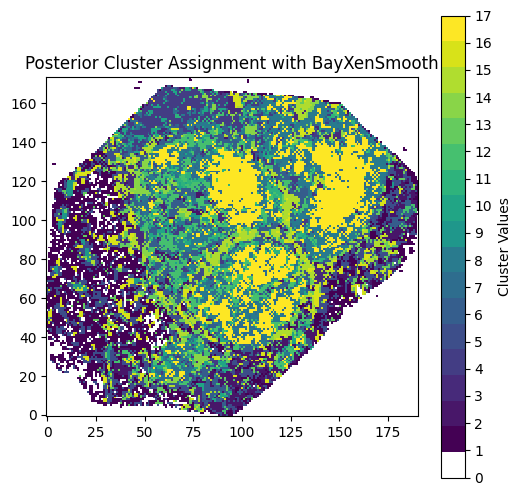

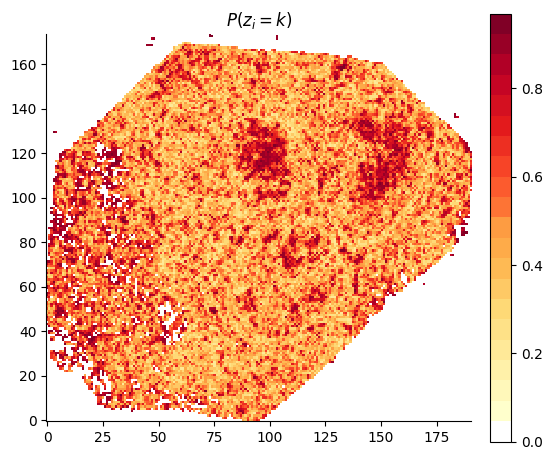

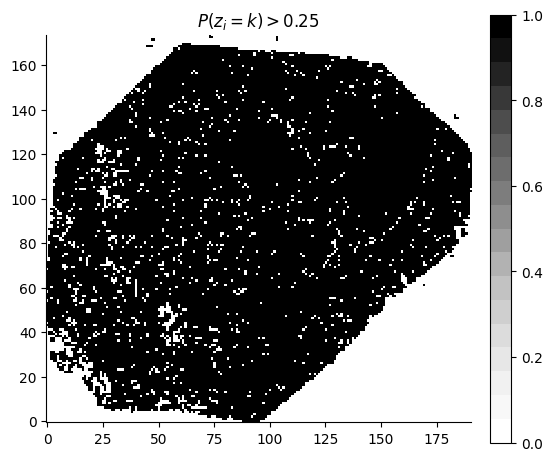

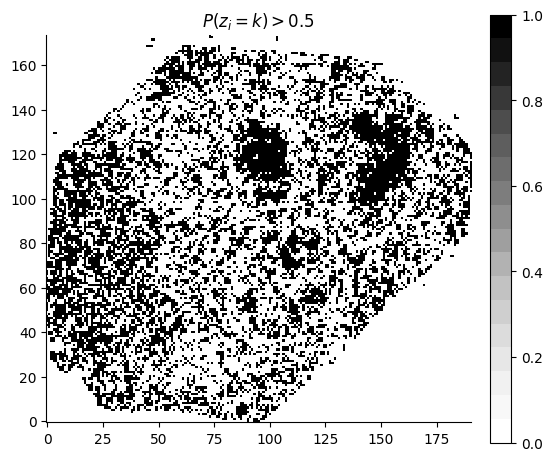

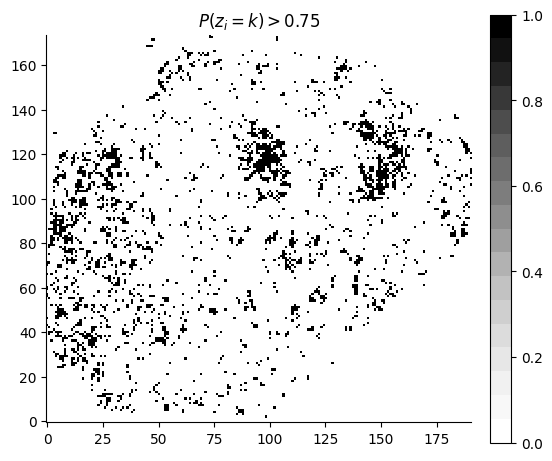

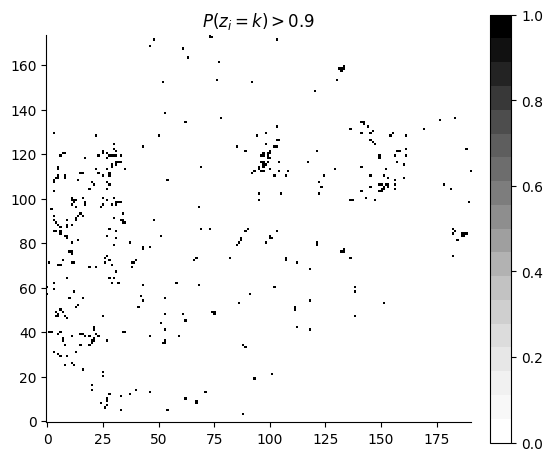

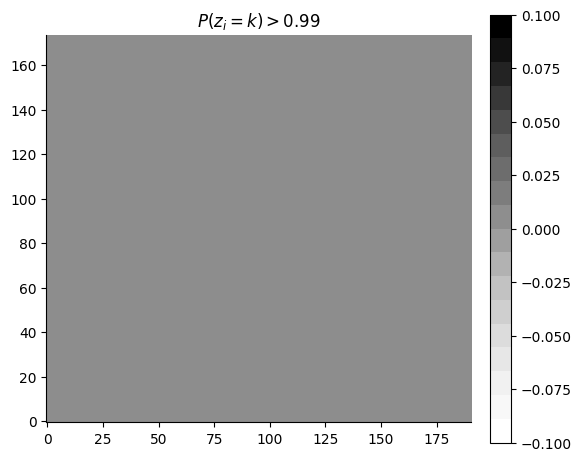

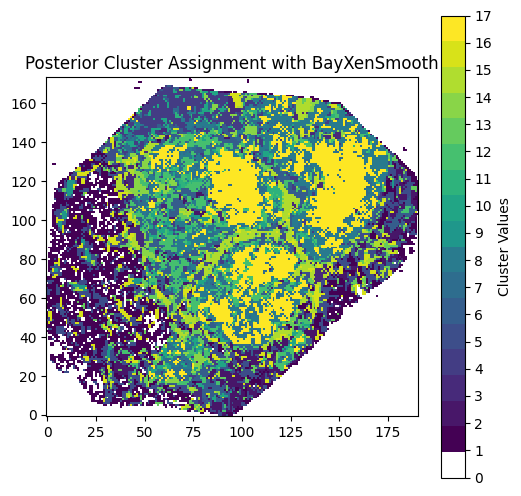

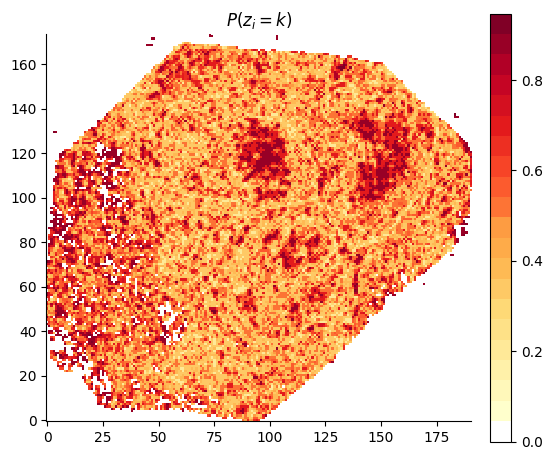

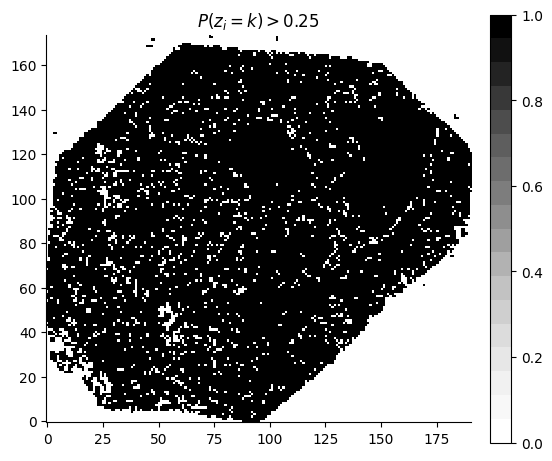

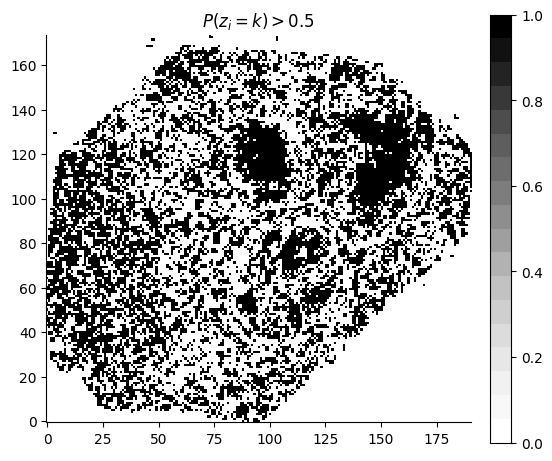

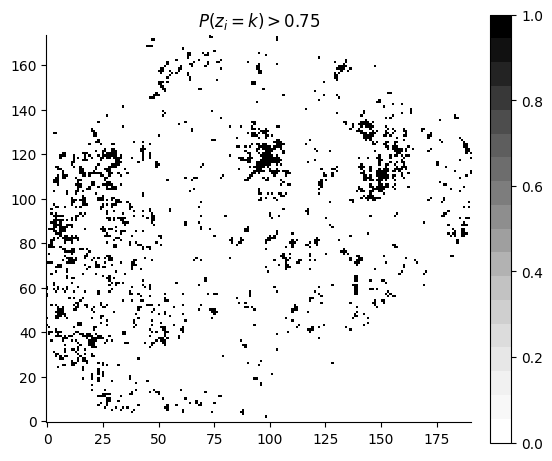

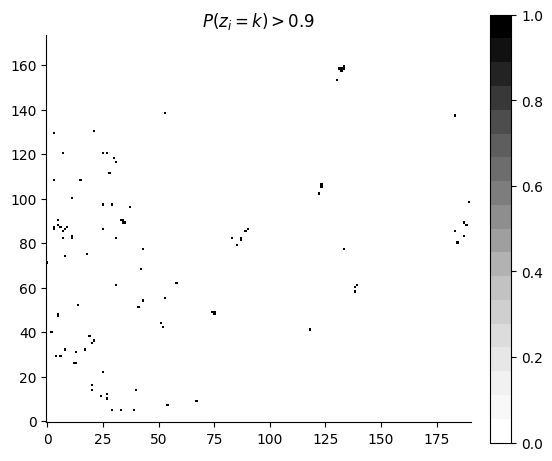

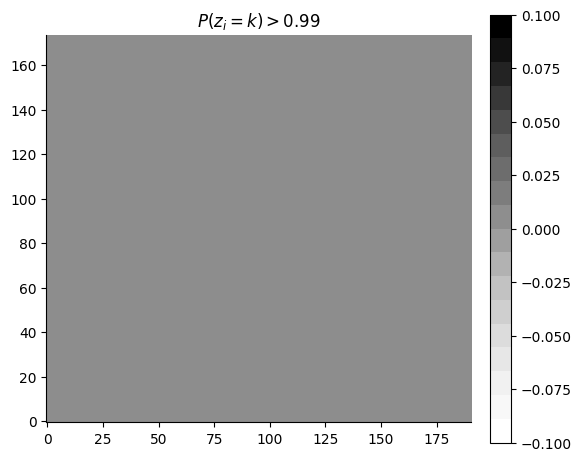

In [80]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 100
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the WSS distance of cluster labels
        wss = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("WSS", sum(wss.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_wss_filepath := save_filepath("BayXenSmooth", "wss", sample_for_assignment)):
            os.makedirs(bayxensmooth_wss_filepath)
        with open(f"{bayxensmooth_wss_filepath}/wss.json", 'w') as fp:
            json.dump(wss, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}

    print(morans_i_markers)

Text(0.5, 1.0, '$P(z_i = k)$')

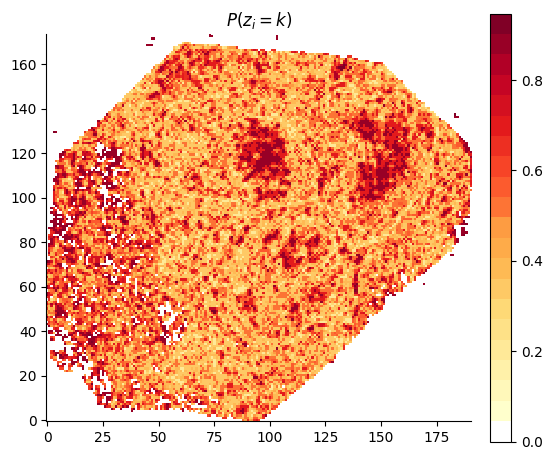

In [81]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

Proportion of Same Labels: 0.48005056381225586


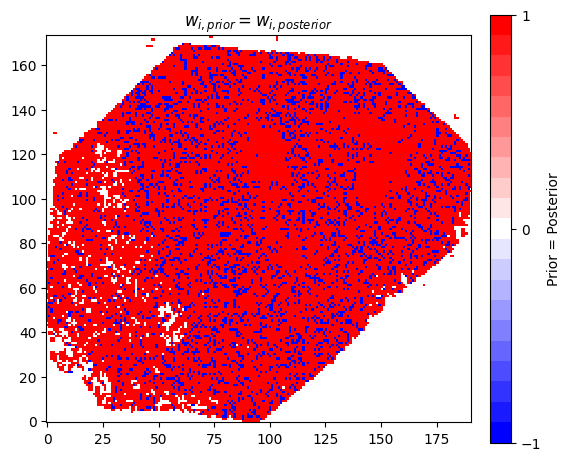

In [82]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')